In [1]:
%%javascript
Jupyter.notebook.config.update({"load_extensions":{"calico-spell-check":true,
                                                  "calico-document-tools":true,
                                                  "calico-cell-tools":true}})

<IPython.core.display.Javascript object>

**Assignment: Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere. Get going by asking the following questions and looking for the answers with some code and plots:**  
>   **1. Can you count something interesting?**  
**2. Can you find some trends (high, low, increase, decrease, anomalies)?**  
**3. Can you make a bar plot or a histogram?**  
**4. Can you compare two related quantities?**  
**5. Can you make a scatterplot?**  
**6. Can you make a time-series plot?**  

**Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?**

**By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?**

----
----

###  **Several stories could be formulated from the SNOTEL and ASOS datasets.  To help frame some stories, here are specific questions I seek to answer in this assignment:**

#### 1. **Are there any additional outliers in the SNOTEL data?**
#### 2. **What is data capture at SNOTEL site? Can the data be interpolated to decrease missing values?**  
#### 3.  **What are annual temperature and snow depth trends for the SNOTEL site?**
#### 4.  **How do ASOS temperatures compare to the SNOTEL temperatures?**
#### 5.  **Is the SNOTEL site typically warmer then then the ASOS site?**
#### 6.  **What is distribution of snow depth for each ski season?**
#### 7.  **When do 12-hr snowfall events >3 occur"?**
#### 8.  **What is distribution of snowfall events by ski season?**  
  
  
  
**The following discusses and shows code inputs/outputs associated with these questions:**

----

### General Setup:

**Import necessary modules:**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt


**Import the ASOS and SNOTEL data as dataframes:**

In [3]:
data = [pd.read_csv('asos_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_df= pd.concat(data)
print(asos_df.head())

data = [pd.read_csv('snotel_df.dat', parse_dates = True, index_col = 'Date_Time')]
snotel_df= pd.concat(data)
print(snotel_df.head())

                     Temperature_degC  Dewpoint_degC  Pressure_hp  \
Date_Time                                                           
2006-01-01 01:00:00              -1.0           -7.0          NaN   
2006-01-01 02:00:00              -3.0           -8.0          NaN   
2006-01-01 03:00:00              -4.0           -8.0          NaN   
2006-01-01 04:00:00              -4.0           -9.0          NaN   
2006-01-01 05:00:00              -5.0           -8.0          NaN   

                     WindDirection_deg  WindSpeed_m/s  CloudCover  \
Date_Time                                                           
2006-01-01 01:00:00              220.0            7.7         NaN   
2006-01-01 02:00:00              230.0            5.1         NaN   
2006-01-01 03:00:00              230.0            3.6         NaN   
2006-01-01 04:00:00              240.0            6.2         NaN   
2006-01-01 05:00:00              210.0            6.2         NaN   

                     1hr_Precipi

----



## Q1: Are there any unrealistic or highly suspect values in the SNOTEL data?  
**To answer this, time series plots of the temperature and snow depth SNOTEL data (snotel_df dataframe) were generated to visually inspect the data to check for anomalous data: **

       TOBS.I-1 (degC)   SNWD.I-1 (in) 
count     104027.000000    91266.000000
mean           1.364769       21.237504
std            9.123291       21.391880
min          -33.100000     -196.000000
25%           -5.000000        0.000000
50%            1.300000       18.000000
75%            7.700000       39.000000
max           25.800000      189.000000


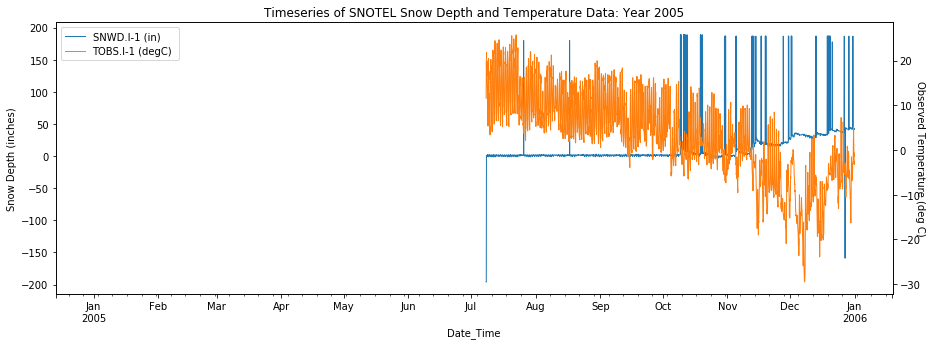

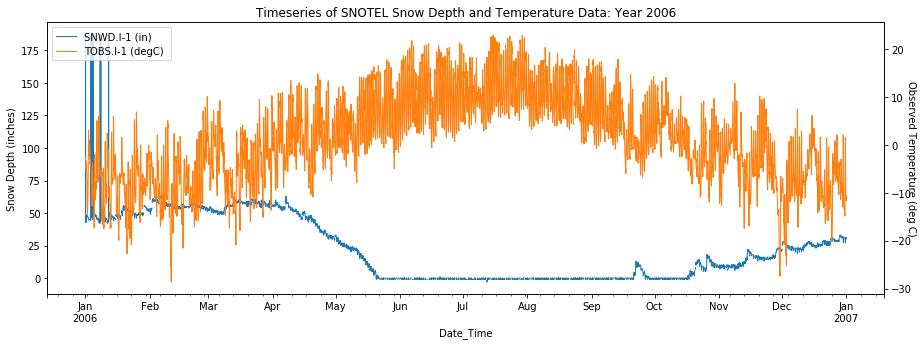

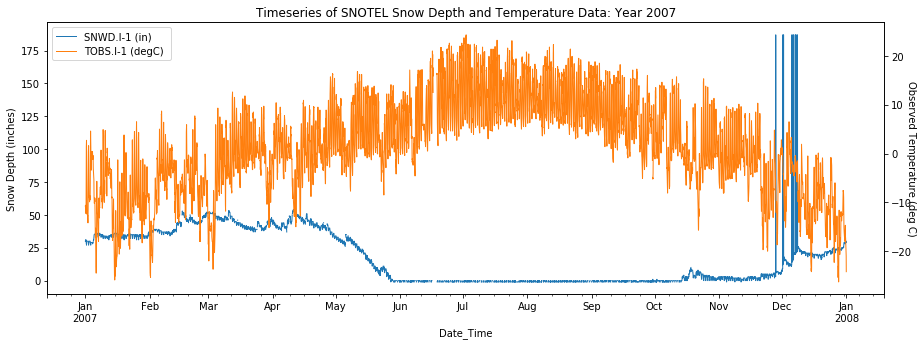

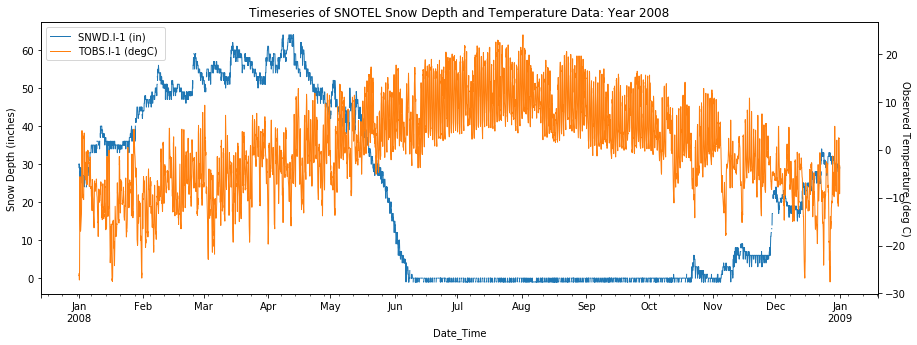

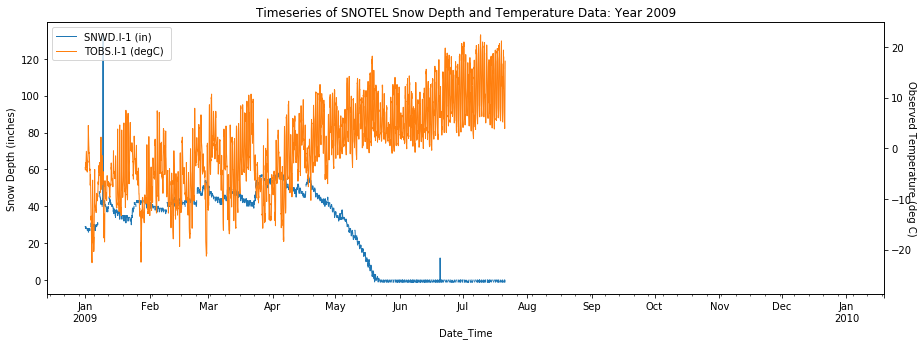

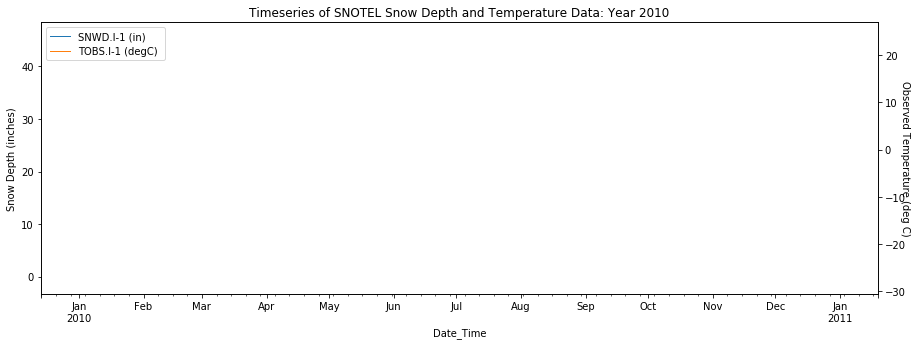

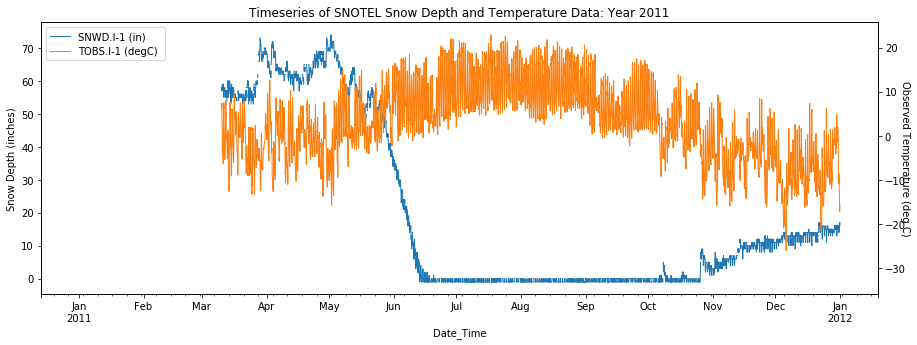

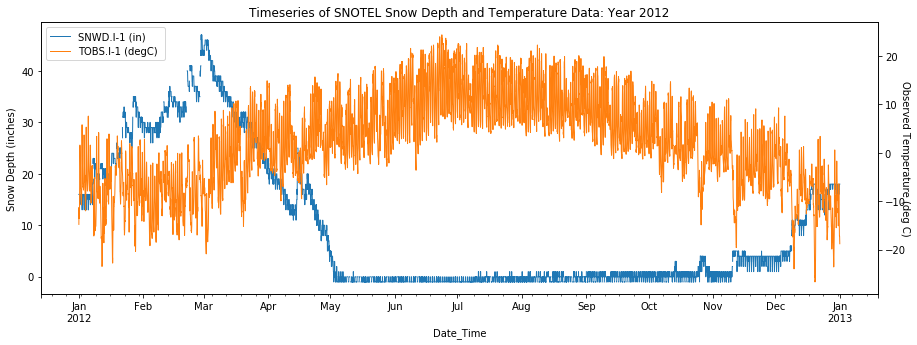

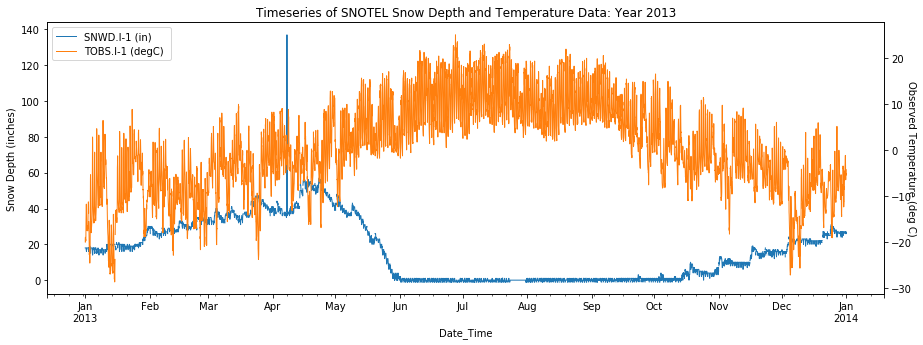

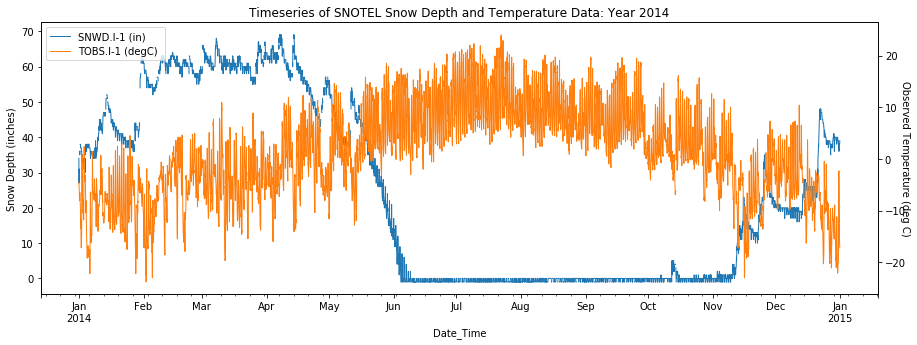

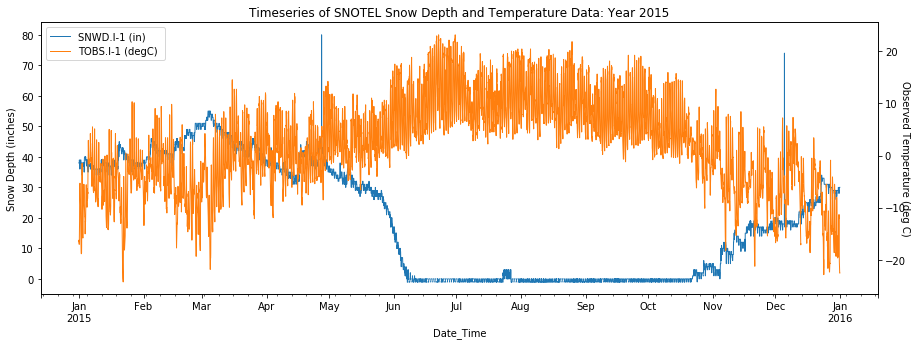

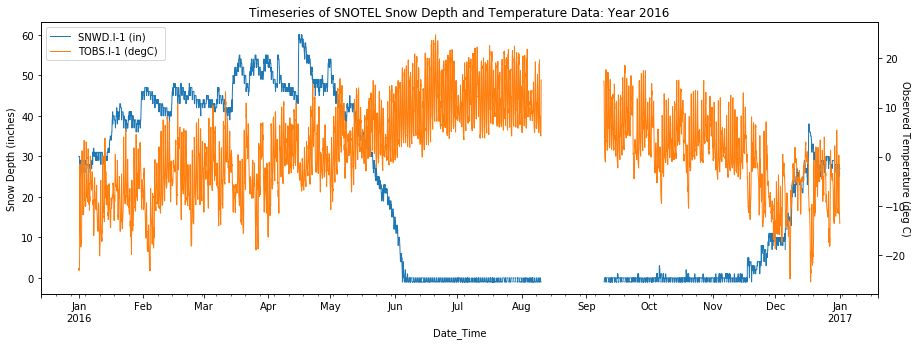

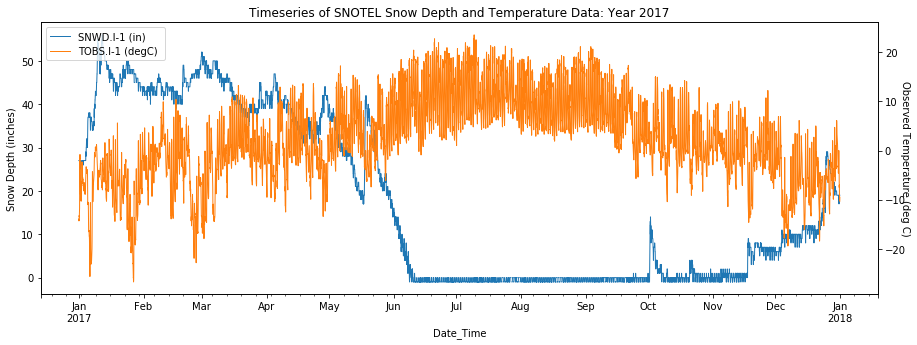

In [4]:
print(snotel_df.describe())

years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

for j in years:
    plt.figure(figsize=(15,5))
    
    ax1 = snotel_df['SNWD.I-1 (in) ']['%04s' % j].plot(use_index=True, linewidth=1)
    ax1.set_ylabel("Date")
    ax1.set_ylabel("Snow Depth (inches)")
    ax1.set_title("Timeseries of SNOTEL Snow Depth and Temperature Data: Year " + j)
   
    ax2 = snotel_df['TOBS.I-1 (degC) ']['%04s' % j].plot(use_index=True, secondary_y = True, linewidth=1)
    ax2.set_ylabel("Observed Temperature (deg C)", rotation = -90)
    
    #Create legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=2)
      
#    plt.savefig('SNWD_TOBS_'+ '%04s' % (j) +'.png')

    plt.show()

 **When plotted, the snow depth timeseries plot does show some anomalies.  There are several unrealistic spikes where it appears >50" fell in a very short amount of time. These are especially apparent in year 2007, 2013, and 2015. These data points are extremely suspect as the spike drops back to more normal values extremely rapidly.  Considering temperatures at the time (hovering around 10 degrees Celsius), rapid snowmelt is physically not possible.  Therefore, these data points were removed from analysis during this exercise.**  
  
**In addition, there is negative spike in the data in year 2006, where the snow depth sensor reported a value of <-100".  This is also an unrealistic measurement, and will also be removed from the dataframe during this analysis.**

**For simplicity, these values will be set to NaN values.  Note that for the capstone project, other ways to account for these values might be explored. **
 

**Based on findings in Q0, the snow depth column of the snotel_df dataframe will be redefined with datapoints >100 inches or <-100 inches being eliminated.**  **Data points >70 inches were also elminated from year 2015.**

In [5]:
xx=(snotel_df['SNWD.I-1 (in) ']<-100) | (snotel_df['SNWD.I-1 (in) ']>100) | (snotel_df['SNWD.I-1 (in) ']['2015']>70)
snotel_df['SNWD.I-1 (in) '][xx]=np.NaN
print(snotel_df['SNWD.I-1 (in) '].describe())


count    91158.000000
mean        21.061256
std         20.634326
min         -3.000000
25%          0.000000
50%         18.000000
75%         39.000000
max         74.000000
Name: SNWD.I-1 (in) , dtype: float64


----
----


## Q2: How much data might be consiered valid at the SNOTEL site?  Can the data be interpolated to decrease missing values?

**To answer this question, annual bar plots showing the percentage of non-missing values for both the temperature and snow depth columns of the snotel_df dataframe are created.  In addition, bar plots of the same variable using a dataframe copy of snotel_df, except hours where 3 or less consecutive missing hours are filled using interpolation. The bar plots were compared to see how the data capture increased due to the interpolation scheme.**  

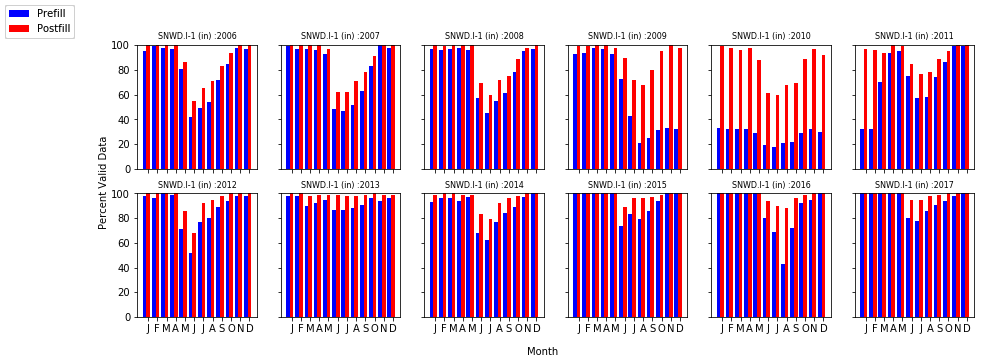

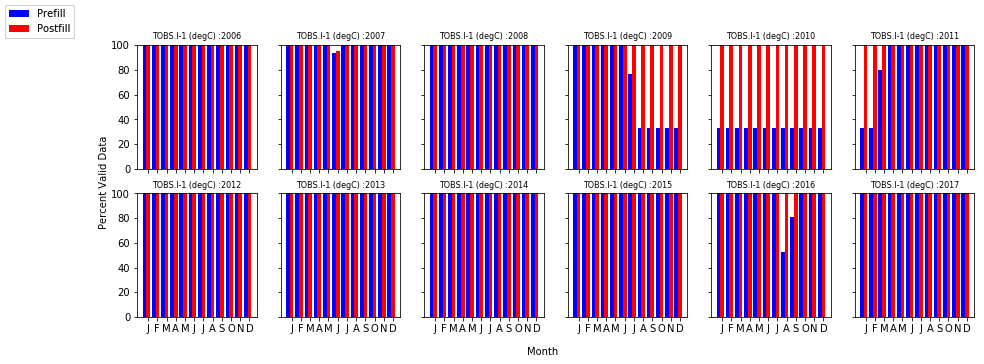

In [6]:
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
#%matplotlib notebook

#create separate figure for the snow depth and temperature columns.  Each figure will contain subplots, one subplot for each year.  Each subplot will contain bars showing data capture (pre and post filling) for each month of that year
for key in ('SNWD.I-1 (in) ','TOBS.I-1 (degC) '):  #snotel_df.keys():#snotel_df[snotel_df.keys() != 'Date_time']:
    
    #set up primary figure to house subplots
    fig,ax1 = plt.subplots(2, 6, sharex = True, sharey = True, figsize=(15,5))
    fig.text(0.5, 0.02, 'Month', ha='center')
    fig.text(0.09, 0.5, 'Percent Valid Data', va='center', rotation='vertical')

            
    for i, a in enumerate(ax1.flatten()):    
        
        if i>len(years)-1: break
        PercentValid = []
        PercentValid_fill = []
        
        #Calculate % missing for each month
        for k in range(12):
            Missing = snotel_df[key]['%02d-%04s' % (k+1,years[i])].isnull().sum()                               #Calcuate number of missing values after interpolation
            Missing_filled = snotel_df[key]['%02d-%04s' % (k+1,years[i])].interpolate(limit=3).isnull().sum()   #Calcuate number of missing values after interpolation
            Possible = len(snotel_df[key]['%02d-%04s' % (k+1,years[i])])
            PercentValid.append(round((1-Missing/Possible)*100))
            PercentValid_fill.append(round((1-Missing_filled/Possible)*100))
        
        # creat subplot
        ind = np.arange(12)
        bar1 = a.bar(ind,PercentValid, width = 0.4, color = 'b', align = 'center')
        bar2 = a.bar(ind+0.4,PercentValid_fill, width = 0.4, color = 'r', align = 'center')
        a.set_title(key + ":" + years[i], fontsize = 8)
        
        a.set_ylim(0,100)
        a.set_xticks(ind+0.4)
        a.set_xticklabels(('J','F','M','A','M','J','J','A','S','O','N','D'))

        fig.legend((bar1, bar2), ('Prefill', 'Postfill'), loc='upper left', fontsize = 10) 
        
    plt.show()

    

----

**The resulting plots show that the percent of temperature data that isn't missing is high for most months, even before filling.  For snow depth, the percent of the data which is non-missing is less then that of temperature. There is a substantial decrease in missing values which result after filling (especially in year 2009 through 2010), demonstrating that many of the missing values are not for long periods of time (< 3hrs). One interesting thing to note is that the percentage of non-missing temperature data before filling hovers around 30% for all months during late 2009 and 2010, but then jumps to 100% after filling.  Considering that about two thirds of the data is missing during this timeframe, there is a high likelihood the pre-filled data only had observations every third hour. Additional investigation into year 2009 and year 2010 might be warranted.**

**Considering that the data filling scheme allowed for the dataset to be more coherent, the a new dataframe (snotel_filled_df) will be created containing these interpolated values and used for all future analyses in this assignment.  Note again that other ways to fill these missing values might be explored the actual Capstone project.**

In [7]:
snotel_filled_df= snotel_df.copy()
snotel_filled_df = snotel_df.interpolate(limit=3)
print(snotel_filled_df.describe())


       TOBS.I-1 (degC)   SNWD.I-1 (in) 
count     114978.000000   106368.000000
mean           1.229866       19.890344
std            9.159036       20.601696
min          -33.100000       -3.000000
25%           -5.200000        0.000000
50%            1.200000       15.000000
75%            7.600000       38.000000
max           25.800000       74.000000


----



## Q3: What are typical annual temperature and snow depth trends at the SNOTEL site?  
**This question was answered by generating timeseries plots similar to those created for Q0, except that the filled snotel_df (snotel_filled_df) will be used.  Timeseries data from the snow depth and temperature columns were again be plotted by year to visually see how temperature and snow depth vary from year to year. **

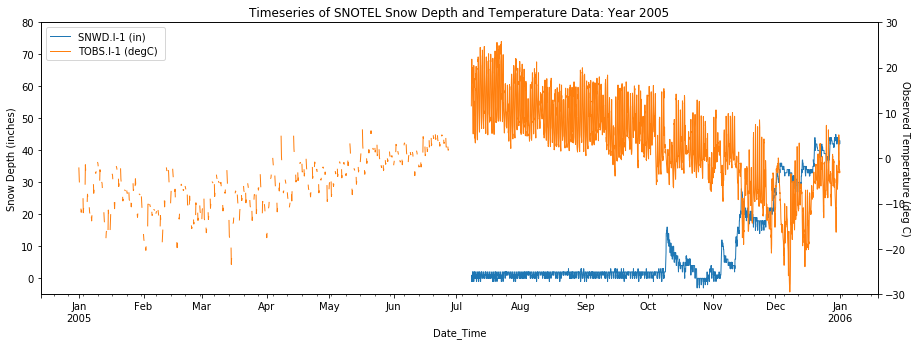

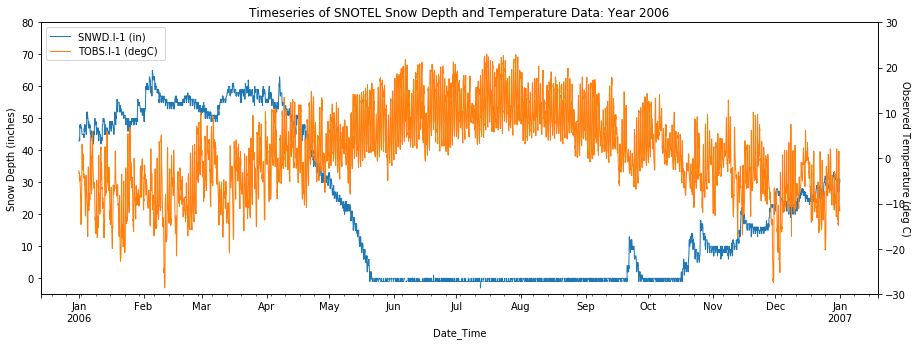

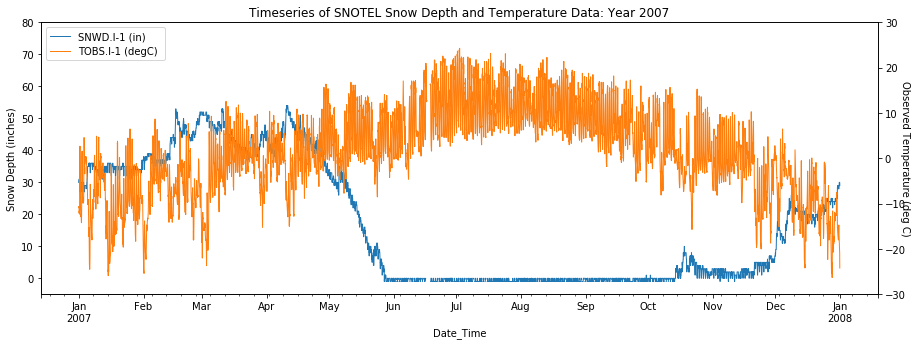

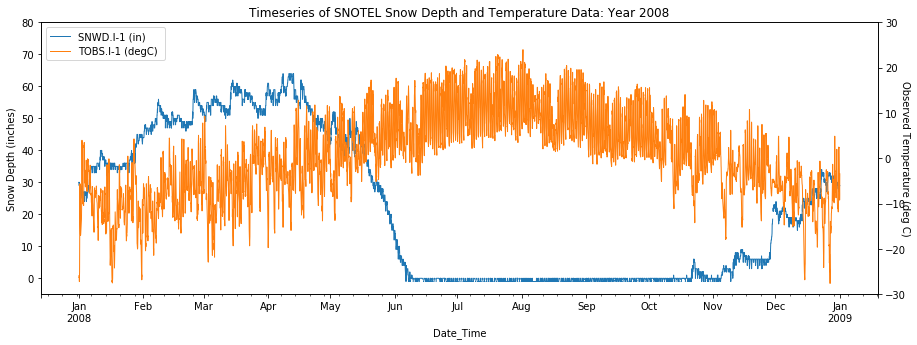

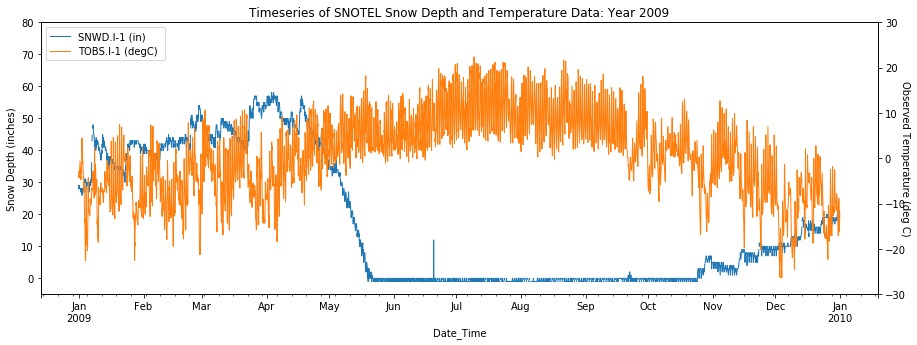

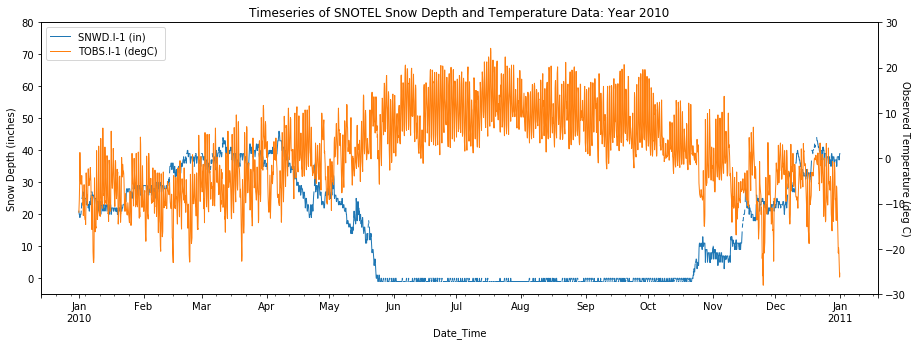

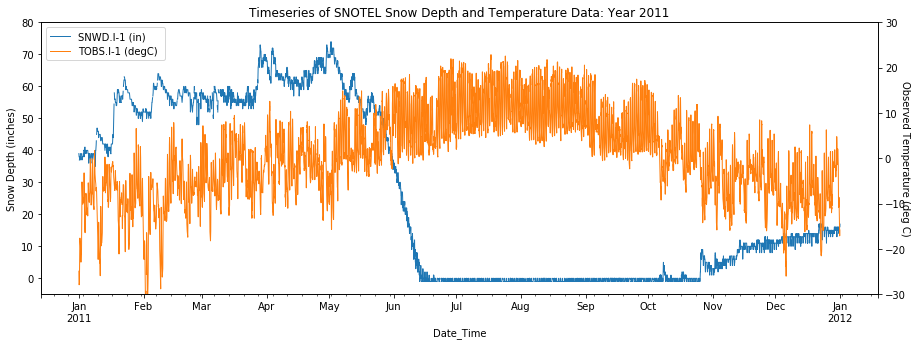

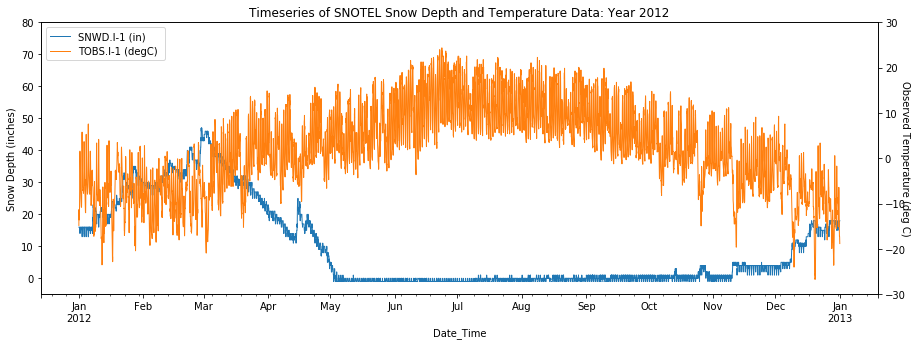

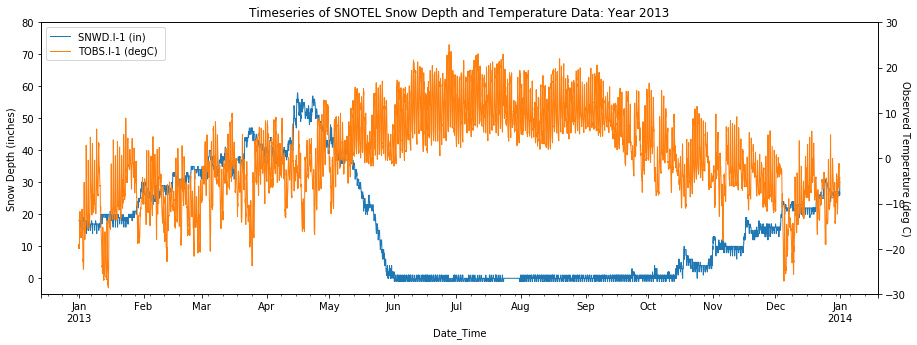

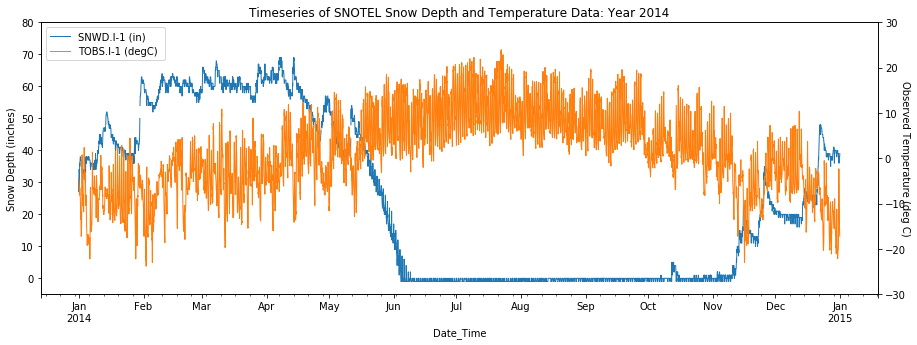

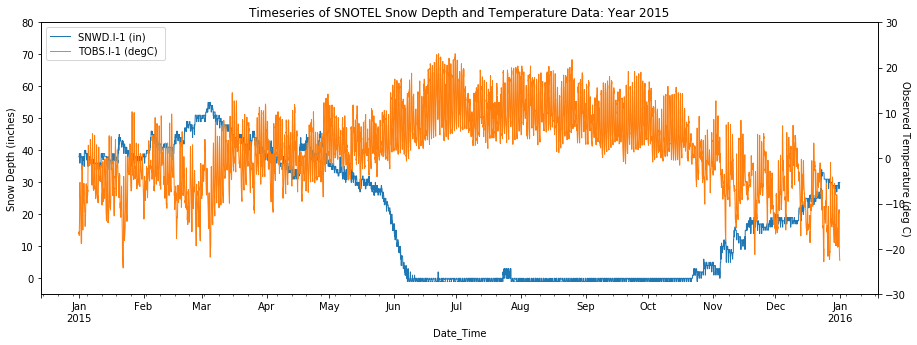

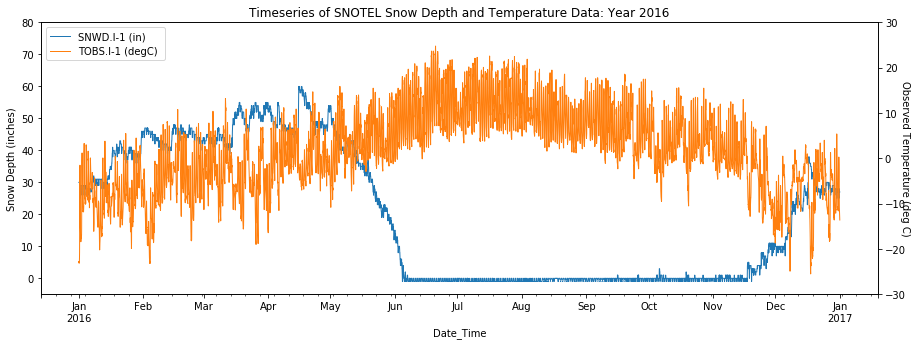

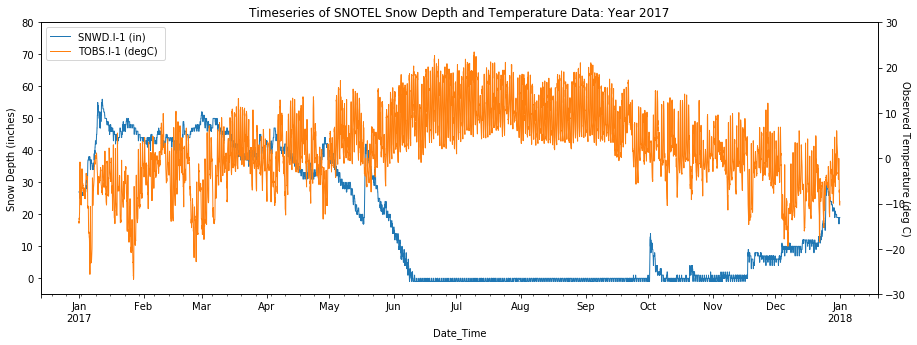

In [8]:
# %matplotlib notebook

years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

for j in years:
    plt.figure(figsize=(15,5))
    
    ax1 = snotel_filled_df['SNWD.I-1 (in) ']['%04s' % j].plot(use_index=True, linewidth=1)
    ax1.set_ylabel("Date")
    ax1.set_ylim(ymin=-5, ymax = 80)
    ax1.set_ylabel("Snow Depth (inches)")
    ax1.set_title("Timeseries of SNOTEL Snow Depth and Temperature Data: Year " + j)
   
    ax2 = snotel_filled_df['TOBS.I-1 (degC) ']['%04s' % j].plot(use_index=True, secondary_y = True, linewidth=1)
    ax2.set_ylabel("Observed Temperature (deg C)", rotation = -90)
    ax2.set_ylim(ymin=-30, ymax = 30)
    
    #Create legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=2)
      
#    plt.savefig('SNWD_TOBS_'+ '%04s' % (j) +'.png')

    plt.show()


-----



**Plots show expected behaviour for the Colorado mountains. Snow begins to consistently accumulate in late October-Mid November, and snowpack disappears in the early May-mid June time frame.  Temperatures follow a seasonal pattern, peaking mid-June to mid-August (where temperature consistently reach above 20 degree C).  The months of December, January, February, and March are marked by cold snaps where temperatures occasionally drop below -20 degrees C. **

## Q4: How do ASOS temperatures compare to the SNOTEL temperatures? 
**Both the ASOS station and the nearby SNOTEL station were recorded temperature measurements during the same time periods, and it is interesting to compare these two datasets. It is a good test to see if the datasets are paired in time - the temperature trends between the two sites should be very similar due to the proximity of the stations to each other.  This comparision was performed by plotting timeseries plots (again, one for each year) which contained the SNOTEL and ASOS temperature series.**

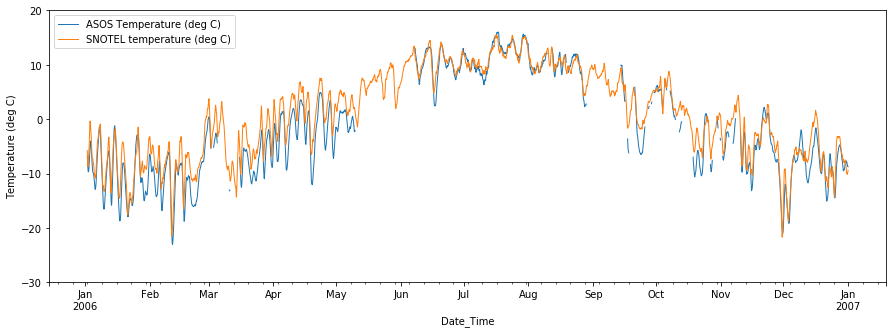

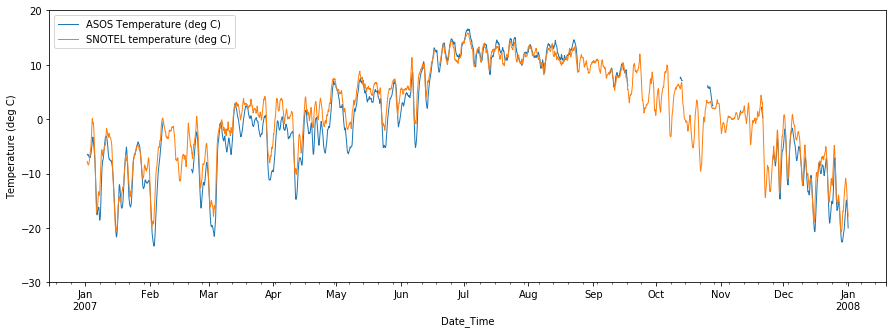

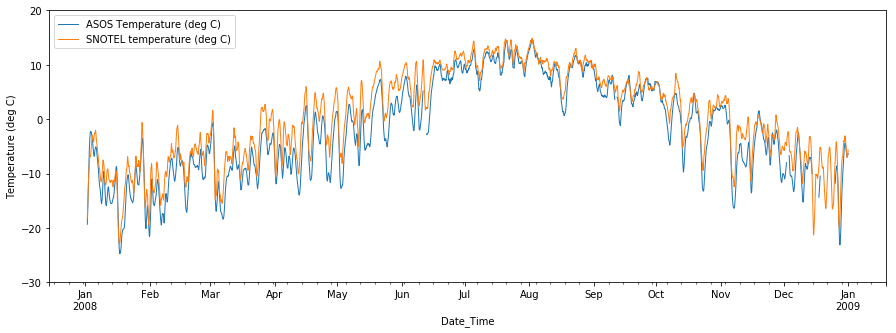

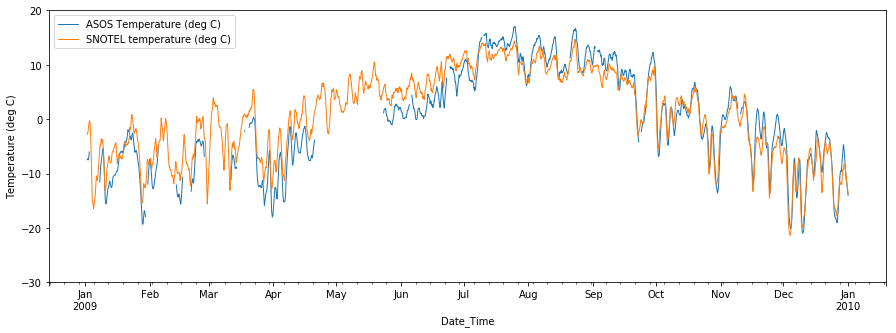

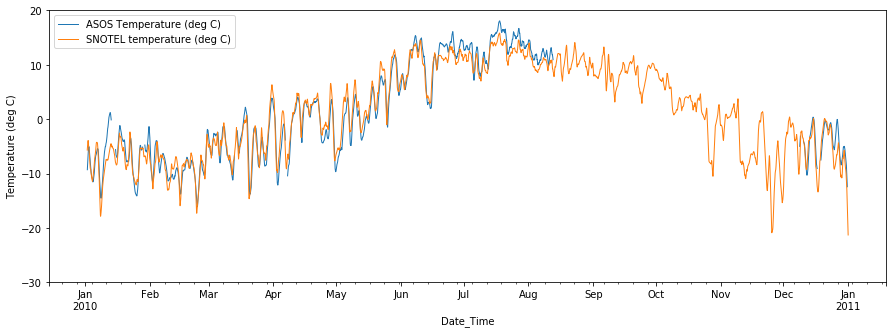

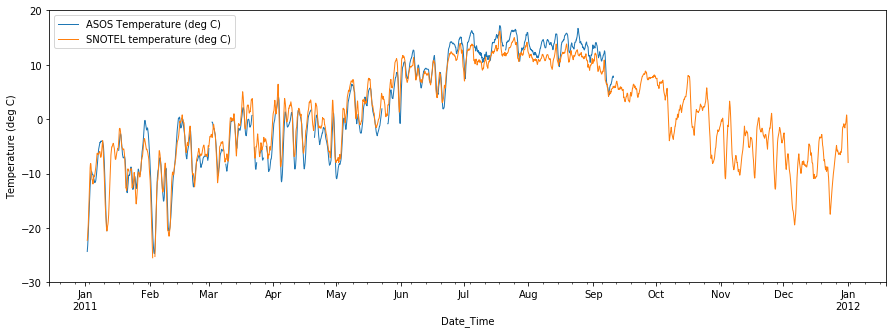

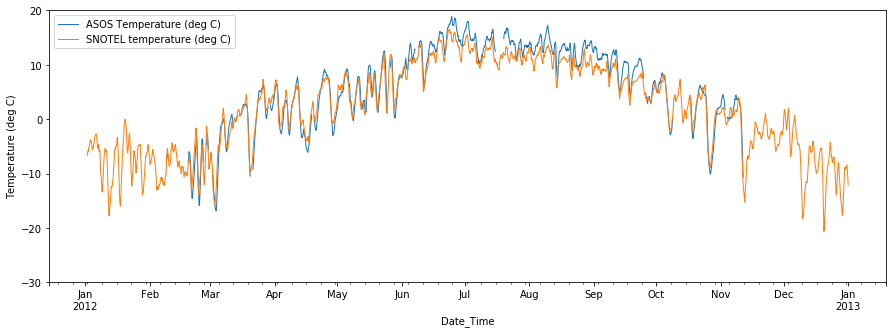

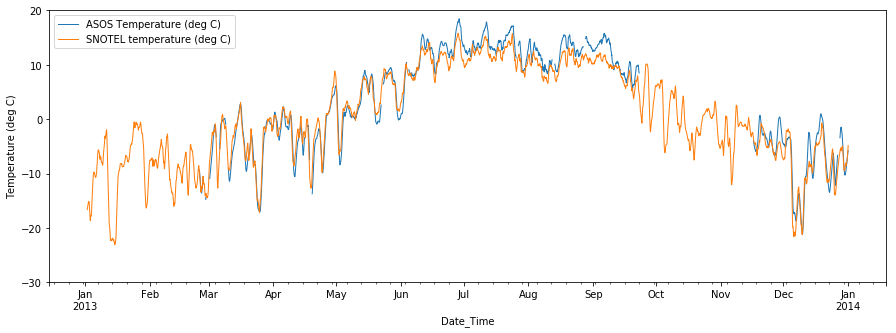

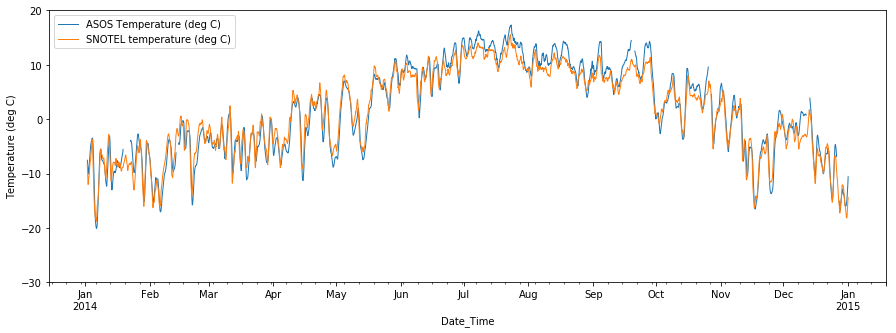

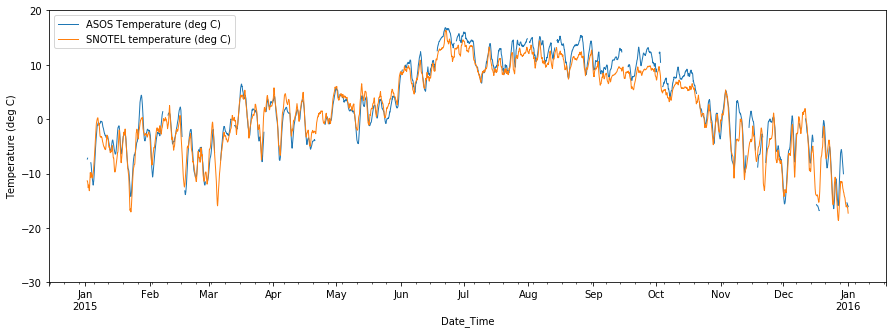

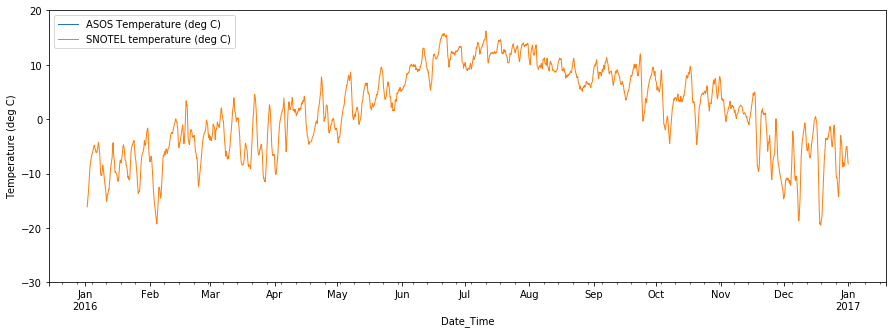

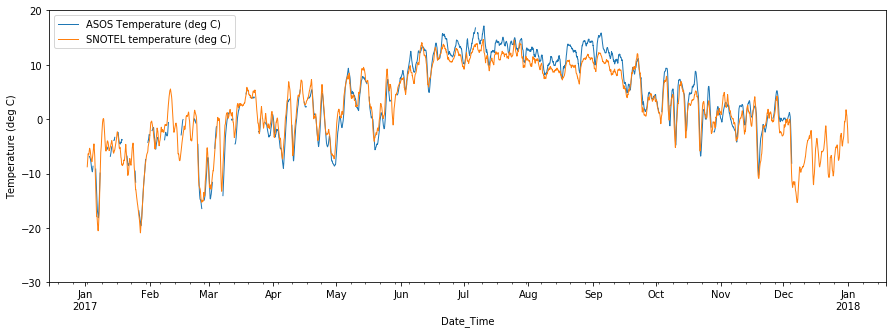

In [9]:
#%matplotlib notebook

years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

for j in years:
    plt.figure(figsize=(15,5))
    ax1 = asos_df['Temperature_degC']['%04s' % j].interpolate(limit=3).rolling(24).mean().plot(use_index=True, linewidth=1)
    ax2 = snotel_filled_df['TOBS.I-1 (degC) ']['%04s' % j].rolling(24).mean().plot(use_index=True, linewidth=1)
    ax1.set_ylabel("Temperature (deg C)")
    #ax2.set_ylabel("Temperature (deg C)", rotation = -90)
    ax1.set_ylim(-30,20)
    #ax2.set_ylim(-30,20)
    
    #Create legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, ['ASOS Temperature (deg C)', 'SNOTEL temperature (deg C)'], loc = 2)
    

#    plt.savefig('SNWD_TOBS_'+ '%04s' % (j) +'.png')
    plt.show()

    

**Plots showed good pairing, as they both tracked well against each other.  However, it appears that the ASOS station might be reporting slightly colder temperatures (especially low temperatures) then the SNOTEL site, though it is hard to determine from the time series plots.  Such behavior would be expected as the ASOS station is located at an elevation of 3680m (12074 ft) whereas the SNOTEL station is located at 3216 m (10550 ft).**

## Q5: Is the SNOTEL site typically warmer then then the ASOS site?
**This question resulted out of Q3 where it was difficult to determine visually which site had warmer temperatures.  To look at this more closely, scatter plots of maximum and minimum daily temperatures (by year) were generated using data from each station to get a better idea which site was warmer.  One to one lines were also drawn on the plots.**

c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  
c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  from ipykernel import kernelapp as app
c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  app.launch_new_instance()
c:\users\rapp\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()


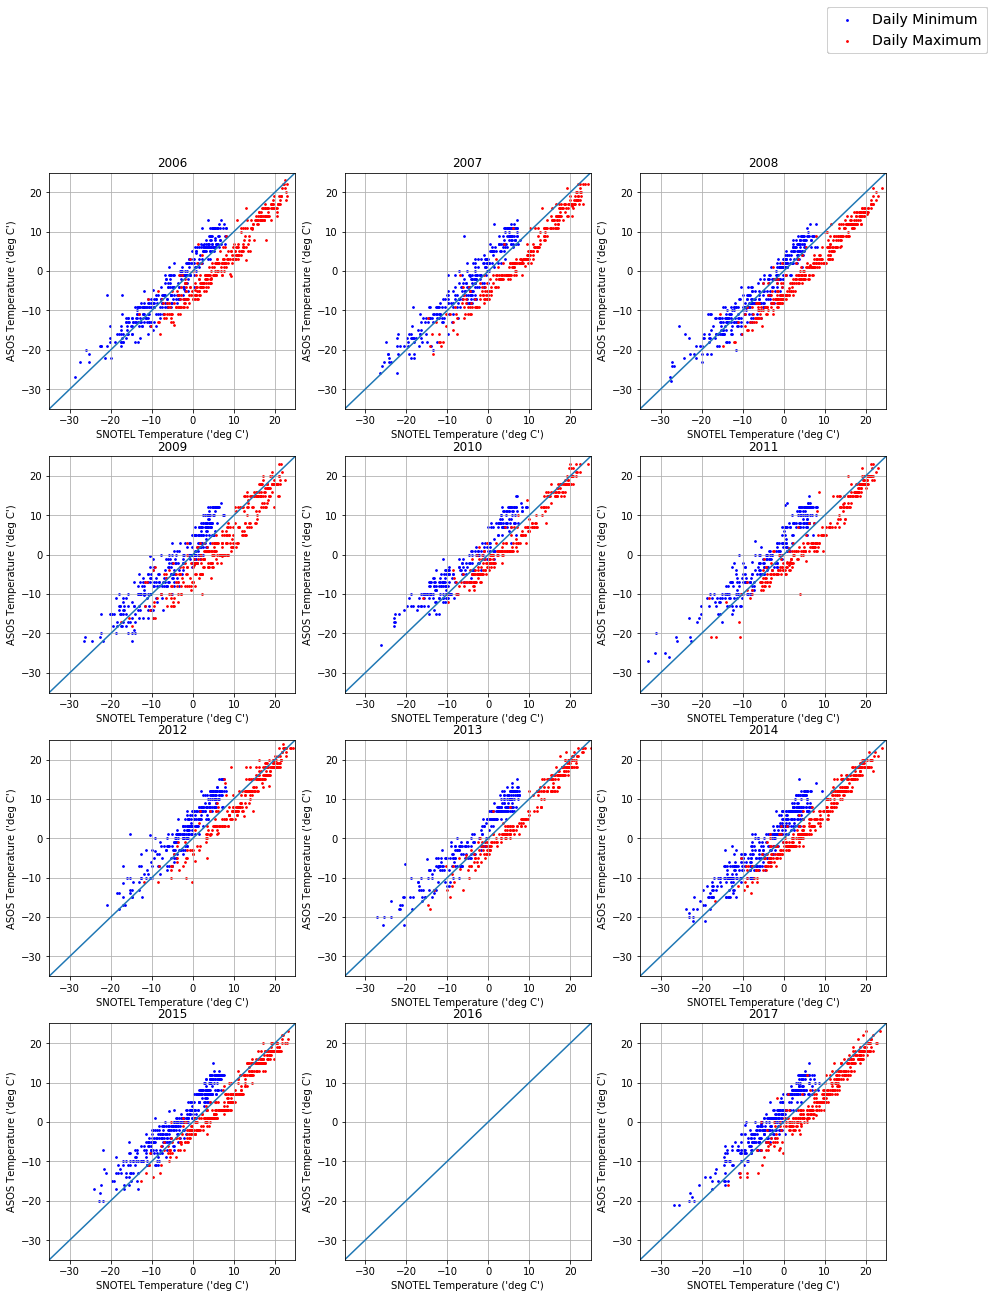

In [10]:
#%matplotlib notebook


fig = plt.figure(figsize=(15,20))
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

for k in range(len(years)):
    ax1 = plt.subplot(4, 3, k+1)
        
        #plt.subplot(4, 3, k+1)
        #plt.figure(figsize=(15,5))
    
    #Find min and max for asos and snotel
    asos_dff_min = asos_df['%04s' % years[k]].interpolate(limit=3).resample('D', how = 'min')
    snotel_dff_min =snotel_filled_df['%04s' % years[k]].resample('D', how = 'min')
    asos_dff_max = asos_df['%04s' % years[k]].interpolate(limit=3).resample('D', how = 'max')
    snotel_dff_max = snotel_filled_df['%04s' % years[k]].interpolate(limit=3).resample('D', how = 'max')

    
    #merge two togetheer
    dff_min =asos_dff_min.merge(snotel_dff_min,right_index=True, left_index=True,how='inner').reset_index()
    dff_max =asos_dff_max.merge(snotel_dff_max,right_index=True, left_index=True,how='inner').reset_index()
    
      
    #plot merged dataframes    
    sct_min = plt.scatter(x=dff_min['TOBS.I-1 (degC) '], y=dff_min['Temperature_degC'], color='Blue', s = 3)
    sct_max = plt.scatter(x=dff_max['TOBS.I-1 (degC) '], y=dff_max['Temperature_degC'], color='Red', s = 3)
    plt.title(years[k])
        
    ax1.set_xlim(-35,25)
    ax1.set_ylim(-35,25)
    
    
    ax1.set_xlabel("SNOTEL Temperature ('deg C')")
    ax1.set_ylabel("ASOS Temperature ('deg C')")
    
    ax1.plot([-35, 25], [-35,25], '-')  #plot 1 to 1 line
    plt.grid(True)
    
    fig.legend((sct_min, sct_max), ('Daily Minimum', 'Daily Maximum'), fontsize = 14) 
    #ax1.legend(h1+h2, ['ASOS Temperature (deg C)', 'SNOTEL temperature (deg C)'], loc = 2)
#    plt.savefig('SNWD_TOBS_'+ '%04s' % (j) +'.png')
plt.show()

**From the plots, the SNOTEL site has slightly warmer maximum temperatures than those observed at the ASOS site; however the SNOTEL site also reports slightly lower daily minimum temperatures. This is an interesting an unexpected finding.  One would expect both the maximum and minimum temperatures to be higher or lower.  Differences in elevation between the two stations, along with the fact that the ASOS station is above treeline and the SNOTEL site isn't may be contributing to this behavior.  Looking at additional statistics of these dataset would be interesting to see.**

## Q6: What is distribution of snow depth data for each ski season?  
**To answer this question, box plots are generated by tabulating snow depth data by ski season the ski season was assumed to be November-April.**  

74.0


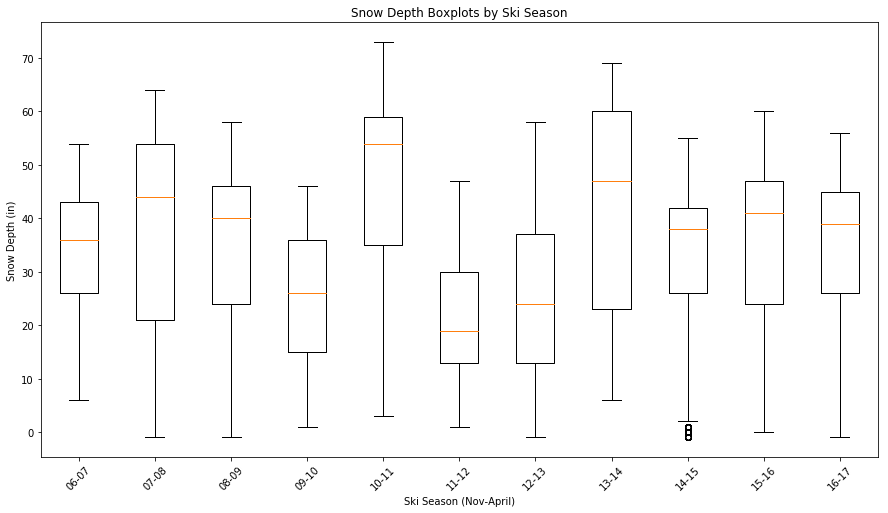

In [11]:
#%matplotlib notebook

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
#fig.suptitle = 'Boxplot by Ski Season (November - April)'

filtered_data = snotel_filled_df['SNWD.I-1 (in) '][~np.isnan(snotel_filled_df['SNWD.I-1 (in) '])]
filtered_data2 = [filtered_data['11-2006':'04-2007'] , filtered_data['11-2007':'04-2008'], \
                 filtered_data['11-2008':'04-2009'],filtered_data['11-2009':'04-2010'],filtered_data['11-2010':'04-2011'], \
                 filtered_data['11-2011':'04-2012'],filtered_data['11-2012':'04-2013'],filtered_data['11-2013':'04-2014'], \
                 filtered_data['11-2014':'04-2015'],filtered_data['11-2015':'04-2016'],filtered_data['11-2016':'04-2017']]
print(filtered_data.max())
plot =ax.boxplot(filtered_data2 )
plt.title('Snow Depth Boxplots by Ski Season')
labels = ['06-07', '07-08', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17']
ax.set_xticklabels(labels, rotation = 45)
ax.set_xlabel('Ski Season (Nov-April)')
ax.set_ylabel('Snow Depth (in)')


#plt.set_xticklabels('06-07', '07-08', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17')
plt.show()

**The generated box plot gives some interesting insights.  First, it can be easily see that the season with the highest mean snowdepth was the 2010-2011 season, and the season with the lowest mean snowdepth was the 2011-2012 season. Breaking this up further by month would be a great next step.**  

## Q7: When did 12-hr snowfall events >3" occur? 
**The intent of this question was to begin explore snowfall events. Snowfall is not a directly measured quantity in the datasets available, and must be estimated with the snow depth dataset. Twelve hour snowfall was calculated at 12 hour interval.  To accomlish this, the hourly snowdepth data was resampled to 12 hours.  The resampled data was then shifted 12 hours forwarded. Twelve-hour snowdepth differences (snowfall) were then be estimated by subtracting the orginaly resampled data from the resampled data which was shifted forward by 12 hours. Snow storms which produced greatter then 3" were then plotted (by year) against the snow depth data.**

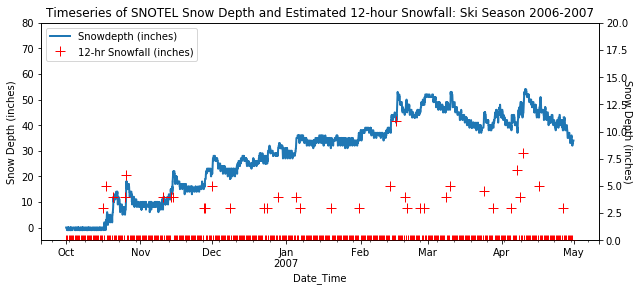

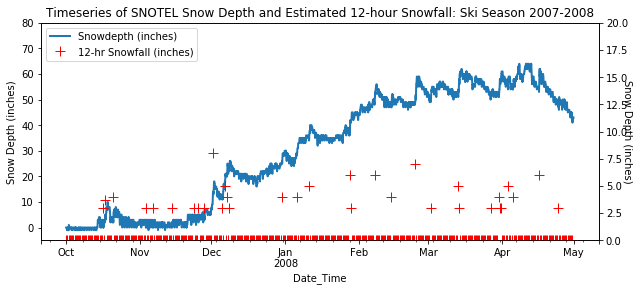

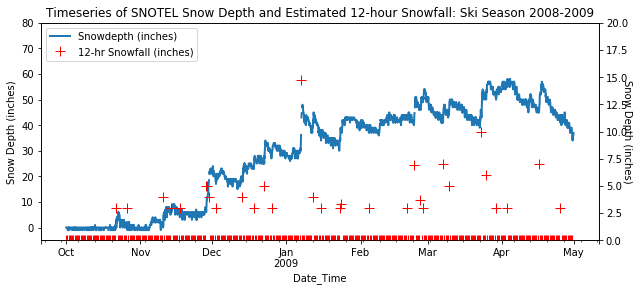

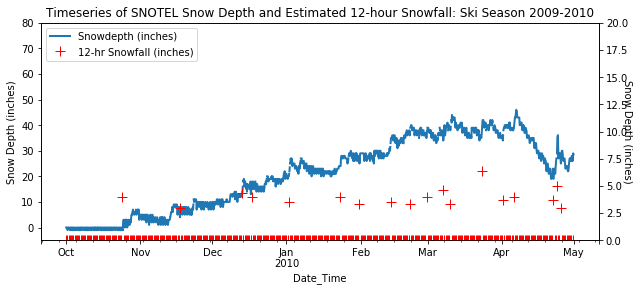

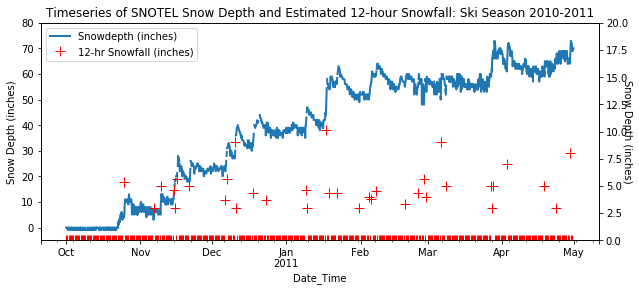

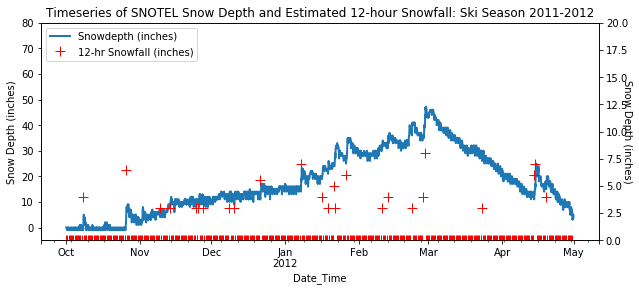

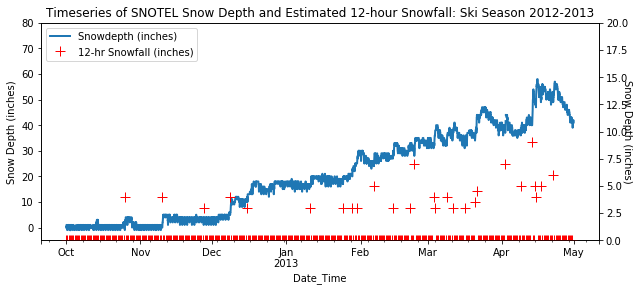

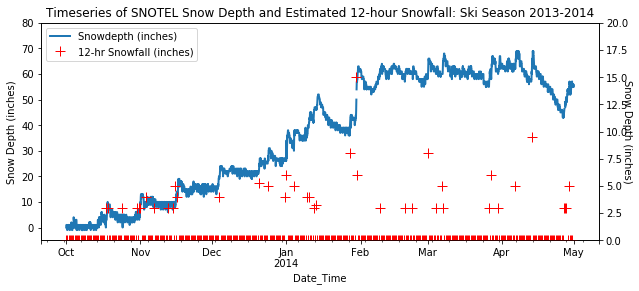

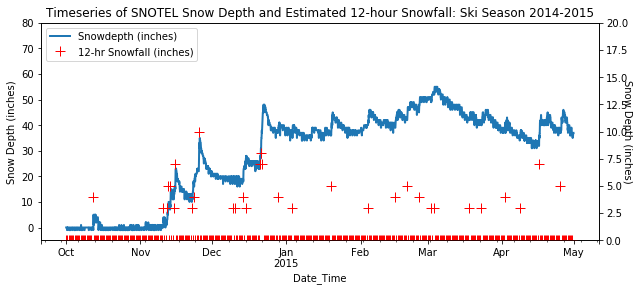

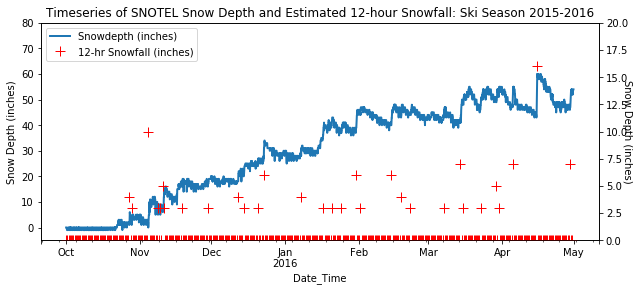

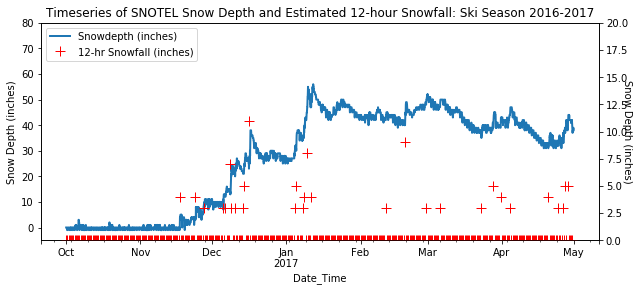

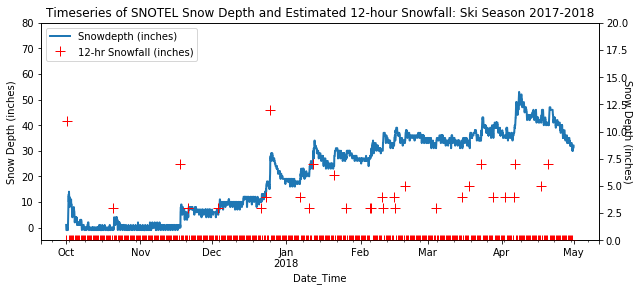

In [12]:
#%matplotlib notebook

#Now calculate 12-snowfall column by finding difference between 12-hr snow depth observations 
snotel_filled_df['12hr_SNWD'] = snotel_filled_df['SNWD.I-1 (in) '].resample('12H').last()
snotel_filled_df['12hr-SNOWFALL'] = snotel_filled_df['12hr_SNWD']-snotel_filled_df['12hr_SNWD'].shift(+12)
#only keep snowfall totals 3 or more"
zz=(snotel_filled_df['12hr-SNOWFALL']<3)
snotel_filled_df['12hr-SNOWFALL'][zz]=0
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']

#['%02d-%04s' % (k+1,j)])
#print(snotel_df['SNWD.I-1 (in) '][('10-2009')].describe())
#print(snotel_df['SNWD.I-1 (in) '][('2009')])

for j in years:
    plt.figure(figsize=(10,4))
    
    #fig, ax = plt.subplots(figsize=(10,4))
    
    #plt1 = plt.plot(snotel_df['SNWD.I-1 (in) ']['2009':'2010'])
    startdate, enddate = '10-%04s' %j, '04-%04d' % (int(j)+1)
    plt1 = snotel_filled_df['SNWD.I-1 (in) '][startdate: enddate].plot(linewidth=2, label = 'SNWD')
    plt1.set_xlabel("Date")
    plt1.set_ylim(ymin=-5, ymax = 80)
    plt1.set_ylabel("Snow Depth (inches)")
    plt1.set_title("Timeseries of SNOTEL Snow Depth and Estimated 12-hour Snowfall: Ski Season " + j + "-" + str(int(j)+1))
    #ax2 = ax.twinx()
    
    plt2 = snotel_filled_df['12hr-SNOWFALL'][startdate: enddate].plot(secondary_y = True, marker='+', linewidth = 0, label = '12-hr-SNOWFALL', markersize = 10, color = 'r')
    plt2.set_ylim(ymin=0, ymax = 20)
    plt2.set_ylabel("Snow Depth (inches)", rotation = -90)
    
    #Create legend
    h1, l1 = plt1.get_legend_handles_labels()
    h2, l2 = plt2.get_legend_handles_labels()
    plt1.legend(h1+h2, ['Snowdepth (inches)','12-hr Snowfall (inches)'], loc=2)
    plt.show()
    


**As expected the larger snowfall events correspond to the spikes in the snow depth

## Q8: What is distribution of snowfall events by ski season?  
**This answer was answered by creating a box plot. A box was generated for each ski season, showing mean, 25th and 75th percentile values.**

18.0


Text(0,0.5,'Snowfall Amount (in)')

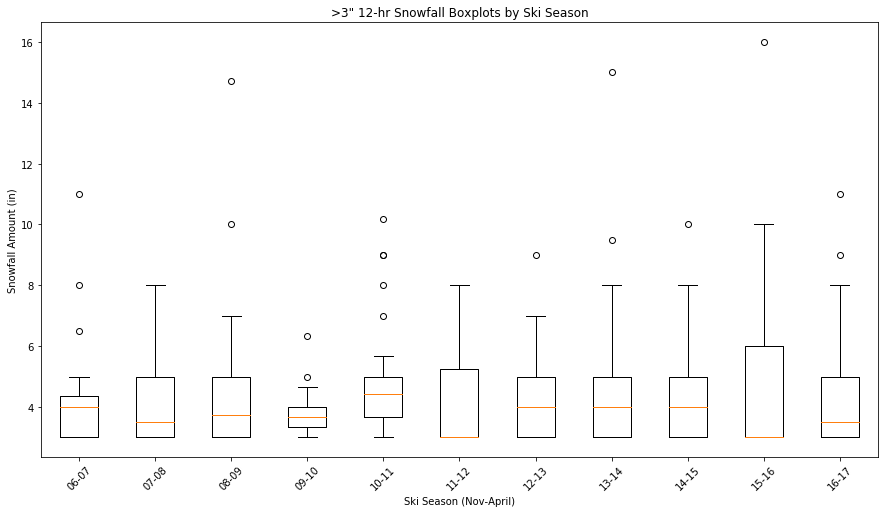

In [13]:
#%matplotlib notebook

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
#fig.suptitle = 'Boxplot by Ski Season (November - April)'

filtered_data = snotel_filled_df['12hr-SNOWFALL'][~np.isnan(snotel_filled_df['12hr-SNOWFALL']) & snotel_filled_df['12hr-SNOWFALL']>0]
filtered_data2 = [filtered_data['11-2006':'04-2007'] , filtered_data['11-2007':'04-2008'], \
                 filtered_data['11-2008':'04-2009'],filtered_data['11-2009':'04-2010'],filtered_data['11-2010':'04-2011'], \
                 filtered_data['11-2011':'04-2012'],filtered_data['11-2012':'04-2013'],filtered_data['11-2013':'04-2014'], \
                 filtered_data['11-2014':'04-2015'],filtered_data['11-2015':'04-2016'],filtered_data['11-2016':'04-2017']]
print(filtered_data.max())
plot =ax.boxplot(filtered_data2 )
plt.title('>3" 12-hr Snowfall Boxplots by Ski Season')
labels = ['06-07', '07-08', '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16', '16-17']
ax.set_xticklabels(labels, rotation = 45)
ax.set_xlabel('Ski Season (Nov-April)')
ax.set_ylabel('Snowfall Amount (in)')

**As can be seen from the box plot, the mean snowfall (per storm) is just 3-4".  The largest snowfalls looked to have occurred in the 2015-2016 season.  Interestingly enough, the mean snowfall for the 2015-2016 season was also the lowest of all the season. This discrepancy should deserve a little more investigation.  However, the 2015-16 season also had the largest spread (the difference between the 25th and 75th percentiles was the largest of all the seasons).  Looking at the snowfall plots created with Q7, year the 2015-2016 season was characterized by some very large snowfalls in the first half, so this wide spread of snowfall amounts might be expected.**